# Install libs

## General libs

In [1]:
!pip install --user ir_datasets
!pip install joblib
!pip install dill

## Text processing libs

In [2]:
!pip install nltk

import nltk
nltk.download()

!pip install contractions

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


## TF-IDF libs

In [3]:
!pip install scikit-learn
!pip install numpy

## Embedding libs

In [4]:
!pip install chromadb
!pip install sentence_transformers
!pip install torch

## BM25 libs

In [5]:
!pip install rank_bm25

## Plotting libs

In [6]:
!pip install --user matplotlib

# Evaluation

## Loader

In [7]:
# Dataset configurations
DATASETS = {
    "antique": {
        "name": "antique",
        "description": "Question-answer dataset with natural questions from real users",
        "ir_datasets_id": "antique",
        "ir_datasets_test_id": "antique/test/non-offensive"
    },
    "quora": {
        "name": "beir/quora",
        "description": "Quora question pairs dataset from the BEIR benchmark",
        "ir_datasets_id": "beir/quora",
        "ir_datasets_test_id": "beir/quora/dev"
    },
    "webis": {
        "name": "beir/webis-touche2020/v2",
        "description": "Webis Touché 2020 (v2) dataset from the BEIR benchmark",
        "ir_datasets_id": "beir/webis-touche2020/v2",
        "ir_datasets_test_id": "beir/webis-touche2020/v2"
    },
    "recreation": {
        "name": "lotte/recreation/dev",
        "description": "LOTTE Recreation domain, development split",
        "ir_datasets_id": "lotte/recreation/dev/forum",
        "ir_datasets_test_id": "lotte/recreation/test/forum"
    },
    "wikir": {
        "name": "wikir/en1k",
        "description": "Wiki-Retrieval English 1K dataset",
        "ir_datasets_id": "wikir/en1k",
        "ir_datasets_test_id": "wikir/en1k/test"
    },
    "clinical": {
        "name": "clinicaltrials/2021/trec-ct-2021",
        "description": "ClinicalTrials TREC-CT 2021 dataset",
        "ir_datasets_id": "clinicaltrials/2021/trec-ct-2021",
        "ir_datasets_test_id": "clinicaltrials/2021/trec-ct-2021/test"
    }
}

# Default dataset to use if none specified
DEFAULT_DATASET = "antique"

In [8]:
import ir_datasets

from typing import TypeAlias

from collections import namedtuple

Doc = namedtuple('Doc', ['doc_id', 'text'])
Query = namedtuple('Query', ['query_id', 'text'])
Qrel = namedtuple('Qrel', ['query_id', 'doc_id', 'relevance', 'iteration'])

def load_dataset(name: str) -> list[Doc]:
    dataset = ir_datasets.load(DATASETS[name]['ir_datasets_id'])
    
    docs = list(dataset.docs_iter())
    return docs

def load_queries_and_qrels(name: str) -> tuple[list[Query], list[Qrel]]:
    dataset_test = ir_datasets.load(DATASETS[name]['ir_datasets_test_id'])
    
    queries = list(dataset_test.queries_iter())
    qrels = list(dataset_test.qrels_iter())
    return queries, qrels

def load_dataset_with_queries(name: str) -> tuple[list[Doc], list[Query], list[Qrel]]:
    dataset = ir_datasets.load(DATASETS[name]['ir_datasets_id'])
    dataset_test = ir_datasets.load(DATASETS[name]['ir_datasets_test_id'])
    
    docs = list(dataset.docs_iter())
    queries = list(dataset_test.queries_iter())
    qrels = list(dataset_test.qrels_iter())
    
    return docs, queries, qrels

## Text Processing

In [9]:
import re
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
import contractions

class TextPreprocessor:
    __lemmatizer__ = WordNetLemmatizer()
    __stop_words__ = set(stopwords.words('english'))
    __instance__ = None

    @staticmethod
    def getInstance():
        if TextPreprocessor.__instance__ == None:
            TextPreprocessor.__instance__ = TextPreprocessor()
        return TextPreprocessor.__instance__

    def __clean_text__(self, text):
        """
        Clean text by removing special characters and converting to lowercase
        """
        # Convert to lowercase
        text = contractions.fix(text)

        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        return text

    def __remove_stopwords__(self, text):
        """
        Remove common stopwords from text
        """
        words = word_tokenize(text)
        filtered_words = [word for word in words if word not in self.__stop_words__]
        return ' '.join(filtered_words)

    def __get_wordnet_pos__(self, tag_parameter):
        tag = tag_parameter[0].upper()
        tag_dict = {
            "J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV
            }
        return tag_dict.get(tag, wordnet.NOUN)

    def __lemmatize_text__(self, text):
        """
        Lemmatize words to their root form
        """
        # Tokenize into words
        words = word_tokenize(text)

        # POS tagging
        pos_tags = pos_tag(words)

        lemmatized_words = [self.__lemmatizer__.lemmatize(word, pos=self.__get_wordnet_pos__(tag)) for word, tag in pos_tags]

        return ' '.join(lemmatized_words)

    def preprocess_text(self, text):
        """
        Apply full preprocessing pipeline
        """
        if not isinstance(text, str):
            return ""
        
        # Apply all preprocessing steps
        text = self.__clean_text__(text)
        text = self.__lemmatize_text__(text)
        text = self.__remove_stopwords__(text)

        return word_tokenize(text.strip())


## Inverted Index

In [10]:
from collections import defaultdict

class InvertedIndex:
    def __init__(self):
        self.index = defaultdict(set)        # term -> {doc_id}
        self.doc_lengths = defaultdict(int)  # doc_id -> total terms
        self.N = 0                           # total documents

    def add_document(self, doc_id, tokens):
        self.N += 1
        self.doc_lengths[doc_id] = len(tokens)
        for token in tokens:
            self.index[token].add(doc_id)

    def get_documents_sharing_terms_with_query(self, query_tokens):
        """
        Returns a set of doc_ids that share at least one word with the query.
        """
        related_docs = set()

        for token in query_tokens:
            related_docs.update(self.index.get(token, set()))

        return list(related_docs)


## Models

### Retriever

In [11]:
import math

def calc_dcg(relevance, rank):
    return ((2 ** relevance) - 1) / math.log2(rank + 1)

class Retriever:
    def search(self, dataset_name: str, query: str, top_k: int = 10, with_index: bool = True) -> list[tuple[str, float, str]]:
        raise NotImplementedError()
    
    def evaluateNDCG(self, dataset_name, queries, qrels, docs, K = 10, print_more = False):
        nDCG = []

        for i in range(len(queries)):
            query = queries[i]
            if print_more:
                preprocess_text = TextPreprocessor.getInstance().preprocess_text
                print(f"Query: {query.text}")
                print(f"Query: {preprocess_text(query.text)}")
            
            # Search
            results = self.search(dataset_name, query.text, K, True)
            if print_more:
                for i, res in enumerate(results):
                    print(f"Result #{i} {res[1]}: {res[2]}")
                    print(f"Result #{i} {res[1]}: {preprocess_text(res[2])}")

            # Find relevant documents for this query
            relevant_qrels = [qrel for qrel in qrels if qrel.query_id == query.query_id]
            relevant_qrels = sorted(relevant_qrels, key=lambda x: x.relevance, reverse=True)
            if print_more:
                for i, qrel in enumerate(relevant_qrels[:K]):
                    doc = [doc for doc in docs if qrel.doc_id == doc.doc_id][0]
                    print(f"Qrel #{i} {qrel.relevance}: {doc.text}")
                    print(f"Qrel #{i} {qrel.relevance}: {preprocess_text(doc.text)}")
            
            DCG = [
                calc_dcg(
                    list(
                        filter(
                            lambda qrel: qrel.doc_id == doc[0], relevant_qrels
                            )
                        )[0].relevance if list(
                        filter(
                            lambda qrel: qrel.doc_id == doc[0], relevant_qrels
                            )
                        ) else 0
                    , i+1
                ) for i, doc in enumerate(results)]
            
            iDCG = [calc_dcg(qrel.relevance, i+1) for i, qrel in enumerate(relevant_qrels[:K])]
            
            res = sum(DCG) 
            ires = sum(iDCG) 
            nDCG.append(res/ires)
            
            if print_more:
                print("")
                print(f"query: {i+1}/{len(queries)}")
                print(f"DCG: {res}")
                print(f"iDCG: {ires}")
                print(f"nDCG: {res/ires*100}%")
            if print_more:
                print(f"Average nDCG: {sum(nDCG)/len(nDCG)*100}%")
        
        nDCG = sum(nDCG)/len(nDCG)*100

        if print_more:
            print(f"Final Average nDCG: {nDCG}%")

        return nDCG

    def evaluateMRR(self, dataset_name, queries, qrels, K = 100, print_more = False):
        MRR = []

        cleaned_qrels: dict[str, dict[str, int]] = {}
        for qrel in qrels:
            if qrel.query_id not in cleaned_qrels.keys():
                cleaned_qrels[qrel.query_id] = {}
            cleaned_qrels[qrel.query_id][qrel.doc_id] = qrel.relevance

        for i in range(len(queries)):
            query = queries[i]
            results = self.search(dataset_name, query.text, K, True)
            
            firstRank = 100
            for ii, res in enumerate(results):
                if res[0] in cleaned_qrels[query.query_id].keys() and cleaned_qrels[query.query_id][res[0]] > 0:
                    firstRank = ii + 1
                    break
            
            MRR.append(1/firstRank)
            
            if print_more:
                print()
                print(f"Query: {i+1}/{len(queries)}")
                print(f"Current MRR: {sum(MRR) / len(MRR) * 100}")
        
        MRR = sum(MRR) / len(MRR) * 100
        if print_more:
            print(f"MRR: {MRR}%")
        return MRR
    
    def evaluateMAP(self, dataset_name, queries, qrels,docs, K = 10, print_more = False):
        MAP = []

        cleaned_qrels: dict[str, dict[str, int]] = {}
        for qrel in qrels:
            if qrel.query_id not in cleaned_qrels.keys():
                cleaned_qrels[qrel.query_id] = {}
            cleaned_qrels[qrel.query_id][qrel.doc_id] = qrel.relevance
        
        for i in range(len(queries)):
            query = queries[i]
            if print_more:
                print()
                print(f'Query: {i+1}/{len(queries)}')
                print(query.text)

            results = self.search(dataset_name, query.text, K, True)
            if print_more:
                print([res[0] for res in results])
                print([qrel.doc_id+f": {qrel.relevance}" for qrel in qrels if qrel.query_id == query.query_id])
                print("results")
                for doc in [doc for doc in docs if doc.doc_id in [res[0] for res in results]]:
                    print(doc.doc_id+" "+doc.text)
                print("qrels")
                koko = [qrel.doc_id for qrel in qrels if qrel.query_id == query.query_id]
                for doc in [doc for doc in docs if doc.doc_id in koko]:
                    print(doc.doc_id+" "+doc.text)

            relevant_num = 0
            precision_sum = 0
            for ii, res in enumerate(results):
                if res[0] in cleaned_qrels[query.query_id].keys() and cleaned_qrels[query.query_id][res[0]] > 0:
                    relevant_num += 1
                    precision_sum += relevant_num / (ii + 1)
            if print_more:
                print(precision_sum)
            if relevant_num > 0:
                MAP.append(precision_sum / relevant_num)
            if print_more:
                if len(MAP) > 0:
                    print(f'MAP = {sum(MAP) / len(MAP) * 100}')
        if len(MAP) > 0:
            MAP = sum(MAP) / len(MAP) * 100
        else:
            MAP = 0
        if print_more:
            print(f'MAP={MAP}%')
        return MAP

    def evaluateAll(self, dataset_name, queries, qrels, K = 10):
            MRR = []
            MAP = []
            nDCG = []

            cleaned_qrels: dict[str, dict[str, int]] = {}
            for qrel in qrels:
                if qrel.query_id not in cleaned_qrels.keys():
                    cleaned_qrels[qrel.query_id] = {}
                cleaned_qrels[qrel.query_id][qrel.doc_id] = qrel.relevance

            for i in range(len(queries)):
                query = queries[i]
                results = self.search(dataset_name, query.text, K, True)
               
                # MRR calc
                firstRank = 10
                for j, res in enumerate(results):
                    if res[0] in cleaned_qrels[query.query_id] and cleaned_qrels[query.query_id][res[0]] > 0:
                        # MRR calc
                        firstRank = j + 1
                        break
                
                # MAP calc
                relevant_num = 0
                precision_sum = 0
                # nDCG calc
                DCG = []
                iDCG = []
                for jj, ress in enumerate(results):
                    if ress[0] in cleaned_qrels[query.query_id] and cleaned_qrels[query.query_id][ress[0]] > 0:
                        # MAP calc
                        relevant_num += 1
                        precision_sum += relevant_num / (jj + 1)
                        # nDCG calc
                        DCG.append(calc_dcg(cleaned_qrels[query.query_id][ress[0]], jj+1))
                    else:
                        # nDCG calc
                        DCG.append(calc_dcg(0, jj+1))
                
                # MRR calc
                MRR.append(1 / firstRank)
                
                # MAP calc
                if relevant_num > 0:
                    MAP.append(precision_sum / relevant_num)
                
                # nDCG calc
                iDCG = [calc_dcg(qrel[1], iii+1) for iii, qrel in enumerate(sorted(list(cleaned_qrels[query.query_id].items()),key = lambda qrel:qrel[1], reverse=True)[:K])]
                res = sum(DCG)
                ires = sum(iDCG)
                nDCG.append(res/ires)
               
            # MRR
            MRR = sum(MRR) / len(MRR) * 100
            
            # MAP    
            if len(MAP) > 0:
                MAP = sum(MAP) / len(MAP) * 100
            else:
                MAP = 0
            
            #nDCG
            nDCG = sum(nDCG) / len(nDCG) * 100
            
            return {
                "MRR": MRR,
                "MAP": MAP,
                "nDCG": nDCG
            }

### tf-idf

In [12]:
import time
import dill
import joblib
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

class TFIDF_online(Retriever):
    __tfidfInstance__ : dict[str, list] = {}
    __invertedIndex__ : dict[str, InvertedIndex] = {}

    @staticmethod
    def __loadInstance__(dataset_name : str):
        if dataset_name not in TFIDF_online.__tfidfInstance__.keys():

            # Load the model and the documents
            docs = load_dataset(dataset_name)
            vectorizer = joblib.load(f"../data/{dataset_name}/tfidf_vectorizer.joblib")
            docs_tfidf_matrix = joblib.load(f"../data/{dataset_name}/tfidf_matrix.joblib")

            TFIDF_online.__tfidfInstance__[dataset_name] = [docs,vectorizer,docs_tfidf_matrix]

    @staticmethod
    def __loadInvertedIndex__(dataset_name : str):
        if dataset_name not in TFIDF_online.__invertedIndex__.keys():
            with open(f"../data/{dataset_name}/inverted_index.dill", "rb") as f:
                inverted_index = InvertedIndex()
                ii = dill.load(f)
                inverted_index.index = ii.index
                inverted_index.doc_lengths = ii.doc_lengths
                inverted_index.N = ii.N
                TFIDF_online.__invertedIndex__[dataset_name] = inverted_index

    def search(self, dataset_name, query, top_k, with_index = True):

        # Load the model and the index
        self.__loadInstance__(dataset_name)
        docs = self.__tfidfInstance__[dataset_name][0]
        vectorizer = self.__tfidfInstance__[dataset_name][1]
        docs_tfidf_matrix = self.__tfidfInstance__[dataset_name][2]
        
        self.__loadInvertedIndex__(dataset_name)
        inverted_index = self.__invertedIndex__[dataset_name]

        # Start the process
        query_vec = vectorizer.transform([query])
        
        if(with_index):
            tokenized_query = TextPreprocessor.getInstance().preprocess_text(query)
            candidate_indices = inverted_index.get_documents_sharing_terms_with_query(tokenized_query)   
            docs_tfidf_matrix = docs_tfidf_matrix[candidate_indices]
            if docs_tfidf_matrix.shape[0] == 0 or query_vec.nnz == 0:
                return []

        cosine_sim = cosine_similarity(query_vec, docs_tfidf_matrix).flatten()

        ranked_indices = np.argsort(cosine_sim)[::-1]

        # Prepare structured results
        results = []
        # Limit results to a reasonable number for display/API response, e.g., top 10 or 20
        for i in ranked_indices[:top_k]:
            if(with_index):
                original_doc_idx = candidate_indices[i]
            else:
                original_doc_idx = i

            doc = docs[original_doc_idx]
            results.append((
                docs[original_doc_idx].doc_id,
                float(cosine_sim[i]),
                doc.text[:40] + "..." if len(doc.text) > 40 else doc.text # Provide a snippet
            ))
        return results


### Embedding

In [13]:
import math
import chromadb
from sentence_transformers import SentenceTransformer, util
import numpy as np
import torch

class Embedding_online(Retriever):
    __embeddingInstance__ : dict[str, any] = {}
    __collection_instance__: dict = {}
    __modelInstance__  = None
    __docs__: dict = {}

    @staticmethod
    def __loadModelInstance__():
        if Embedding_online.__modelInstance__ == None:
            Embedding_online.__modelInstance__ = SentenceTransformer("../data/models/all-MiniLM-L6-v2") 
        return Embedding_online.__modelInstance__

    @staticmethod
    def __loadInstance__(dataset_name : str):
        if dataset_name not in Embedding_online.__embeddingInstance__.keys():
            with open(f"../data/{dataset_name}/bert_embeddings.npy", "rb") as f:
                Embedding_online.__embeddingInstance__[dataset_name] = np.load(f)
        return Embedding_online.__embeddingInstance__[dataset_name]

    @staticmethod
    def __get_collection__(dataset_name: str):
        if dataset_name not in Embedding_online.__collection_instance__:
            client = chromadb.PersistentClient(path=f"../data/{dataset_name}/chroma_db")
            Embedding_online.__collection_instance__[dataset_name] = client.get_collection(name=f"{dataset_name}_embeddings")
        return Embedding_online.__collection_instance__[dataset_name]
    
    @staticmethod
    def __loadDocs__(dataset_name: str):
        if dataset_name not in Embedding_online.__docs__:
            docs = load_dataset(dataset_name)
            Embedding_online.__docs__[dataset_name] = docs
        return Embedding_online.__docs__[dataset_name]
    
    with_index = False

    def search(self, dataset_name: str, query: str, top_k: int = 10, useless_param = None):
        if self.with_index:
            return self.embedding_vectors_search(dataset_name, query, top_k)
        else:
            return self.embedding_search(dataset_name, query, top_k)

    def embedding_search(self, dataset_name: str, query: str, top_k: int):
        # Load model and documents
        model = Embedding_online.__loadModelInstance__()
        document_embeddings =  Embedding_online.__loadInstance__(dataset_name)
        docs =  Embedding_online.__loadDocs__(dataset_name)
        processedQuery = TextPreprocessor.getInstance().preprocess_text(query)
        query_embedding = model.encode(" ".join(processedQuery))

        cos_scores = util.cos_sim(torch.tensor(query_embedding), torch.tensor(document_embeddings))[0]
        top_results = torch.topk(cos_scores, k=top_k)
        results = []
        # print(f"\nTop {top_k} results for query: '{query}'")
        for score, idx in zip(top_results[0], top_results[1]):
            doc_id = docs[idx].doc_id
            doc_text = docs[idx].text[:100] + "..." 
            results.append((doc_id, score.item(), doc_text))
            # print(f"Doc ID: {doc_id}, Score: {score.item():.4f}, Text: {doc_text}"
        return results

    def embedding_vectors_search(self, dataset_name: str, query: str, top_k: int):
        #Load model and collection
        model = Embedding_online.__loadModelInstance__()
        collection = Embedding_online.__get_collection__(dataset_name)
        #process query
        processedQuery = TextPreprocessor.getInstance().preprocess_text(query)
        query_embedding = model.encode(" ".join(processedQuery))
        search_results = collection.query(
            query_embeddings=[query_embedding],
            n_results=top_k
        )
        results = []
        ids = search_results['ids'][0]
        distances = search_results['distances'][0]
        metadatas = search_results['metadatas'][0]
        for doc_id, score, meta in zip(ids, distances, metadatas):
            similarity_score = 1 - score
            text = meta.get('text', '')[:100] + "..." 
            results.append((doc_id, similarity_score, text))
        return results

    def embedding_rerank(self, dataset_name: str, query: str, doc_ids: list) -> list[tuple[str, float]]:
        """
        Efficiently re-ranks a list of documents using the loaded embeddings.
        """

        docs_list = load_dataset(dataset_name)
        document_embeddings =  Embedding_online.__loadInstance__(dataset_name)
        model = Embedding_online.__loadModelInstance__()

        # 1. Create a quick lookup map for doc_id to its index
        doc_id_to_index = enumerate(docs_list)

        # 2. Get the indices and embeddings for the documents we need to rerank
        candidate_indices = [i for i, doc in doc_id_to_index if doc.doc_id in doc_ids]

        # Filter out any docs that might not be in our list
        valid_indices = [idx for idx in candidate_indices if idx is not None]
        
        if not valid_indices:
            return []
            
        candidate_embeddings = document_embeddings[valid_indices]
        
        # 3. Encode the query
        query_embedding = model.encode(query, convert_to_tensor=True)
        
        # 4. Calculate similarity scores
        cosine_scores = util.cos_sim(query_embedding, candidate_embeddings)[0]
        
        # 5. Pair the original doc_ids (that were valid) with their new scores
        valid_doc_ids = [docs_list[i] for i in valid_indices]
        reranked_results = []
        for doc_id, score in zip(valid_doc_ids, cosine_scores):
            reranked_results.append((doc_id, score.item()))

        return sorted(reranked_results, key=lambda item: item[1], reverse=True)

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### bm25

In [14]:
import math
import os
import dill
from rank_bm25 import BM25Okapi

class BM25_online(Retriever):
    __bm25instance__ : dict[str, BM25Okapi] = {}
    __invertedIndex__ : dict[str, InvertedIndex] = {}
    __docs__ : dict[str, list[str, str]] = {}
    @staticmethod
    def __loadInstance__(dataset_name : str):
        if dataset_name not in BM25_online.__bm25instance__.keys():
            with open(os.path.join(os.path.abspath(''), f"../data/{dataset_name}/bm25_model.dill"), "rb") as f:
                BM25_online.__bm25instance__[dataset_name] = dill.load(f) 
        return BM25_online.__bm25instance__[dataset_name]
    @staticmethod
    def __loadInvertedIndex__(dataset_name : str):
        if dataset_name not in BM25_online.__invertedIndex__.keys():
            with open(f"../data/{dataset_name}/inverted_index.dill", "rb") as f:
                inverted_index = InvertedIndex()
                ii = dill.load(f)
                inverted_index.index = ii.index
                inverted_index.doc_lengths = ii.doc_lengths
                inverted_index.N = ii.N
                BM25_online.__invertedIndex__[dataset_name] = inverted_index
        return BM25_online.__invertedIndex__[dataset_name]
    @staticmethod
    def __loadDocs__(dataset_name : str):
        if dataset_name not in BM25_online.__docs__.keys():
            BM25_online.__docs__[dataset_name] = load_dataset(dataset_name)
        return BM25_online.__docs__[dataset_name]

    def search(self, dataset_name: str, query: str, top_k: int = 10, with_inverted_index: bool = True) -> list[tuple[str, float, str]]:
        # Load the model and the documents
        bm25 = BM25_online.__loadInstance__(dataset_name)
        docs = BM25_online.__loadDocs__(dataset_name)
        if with_inverted_index:
            inverted_index = BM25_online.__loadInvertedIndex__(dataset_name)

        # Execute the query
        query_tokens = TextPreprocessor.getInstance().preprocess_text(query)

        if with_inverted_index:
            documents_sharing_terms_with_query = inverted_index.get_documents_sharing_terms_with_query(query_tokens)
            scores = bm25.get_batch_scores(query_tokens, documents_sharing_terms_with_query)
        else:
            scores = bm25.get_scores(query_tokens)

        # Sort the results
        if with_inverted_index:
            top_indices = sorted(list(enumerate(documents_sharing_terms_with_query)), key=lambda  elm: scores[elm[0]], reverse=True)[:top_k]
        else:
            top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]

        results = []

        # Display the results
        if with_inverted_index:
            for elm in top_indices:
                text = docs[elm[1]].text
                results.append((docs[elm[1]].doc_id, scores[elm[0]], text))
        else:
            for idx in top_indices:
                text = docs[idx].text
                results.append((docs[idx].doc_id, scores[idx], text))
        
        return results


### Hybrid

In [15]:
class Hybrid_online(Retriever):
    with_vector_store = False

    def __normalize_scores__(self, ranked_list: list) -> list:
        """
        Normalizes scores in a ranked list to a [0, 1] scale.
        """
        scores = [score for doc_id, score, text in ranked_list]
        if not scores:
            return []
        
        min_score = min(scores)
        max_score = max(scores)
        
        if max_score == min_score:
            return [(doc_id, 1.0) for doc_id, score, text in ranked_list]
        
        normalized_list = []
        for doc_id, score, text in ranked_list:
            normalized_score = (score - min_score) / (max_score - min_score)
            normalized_list.append((doc_id, normalized_score))
        return normalized_list

    def search(self, dataset_name: str, query: str, top_k: int = 10, with_index: bool = True) -> list[tuple[str, float, str]]:
        """
        Performs a complex hybrid search.
        """

        # --- Get the required service modules from the registry ---
        tfidf_service = TFIDF_online()
        bm25_service = BM25_online()
        embedding_service = Embedding_online()
        embedding_service.with_index = self.with_vector_store

        # ==========================================================================
        #  STAGE 1: Parallel Fusion of TF-IDF and BM25
        # ==========================================================================
        
        tfidf_results = tfidf_service.search(dataset_name, query, top_k*2)

        bm25_results = bm25_service.search(dataset_name, query, top_k*2)

        # --- Normalize and Fuse the lexical results ---
        norm_tfidf = self.__normalize_scores__(tfidf_results)
        norm_bm25 = self.__normalize_scores__(bm25_results)

        fused_scores = {}
        tfidf_weight = 0.5
        bm25_weight = 0.5

        for doc_id, score in norm_tfidf:
            fused_scores[str(doc_id)] = score * tfidf_weight

        for doc_id, score in norm_bm25:
            doc_id_str = str(doc_id)
            if doc_id_str in fused_scores:
                fused_scores[doc_id_str] += score * bm25_weight
            else:
                fused_scores[doc_id_str] = score * bm25_weight
                
        # --- Create the final candidate list from Stage 1 ---
        candidate_list = sorted(fused_scores.items(), key=lambda item: item[1], reverse=True)
        
        # Extract just the document IDs for the next stage
        candidate_doc_ids = [doc_id for doc_id, score in candidate_list]
        
        # ==========================================================================
        #  STAGE 2: Serial Re-ranking with Embedding Model
        # ==========================================================================

        # Call the new, efficient rerank function from the embedding service
        final_list = embedding_service.embedding_rerank(dataset_name, query, candidate_doc_ids)
        
        return final_list[:top_k]

## Evaluate

### Antique

In [16]:
antiqueDocs, antiqueQueries, antiqueQrels = load_dataset_with_queries('antique')

### Antique tf-idf

In [17]:
print()
print("Calculating Evaluation for tf-idf")
st = time.time()
ev = TFIDF_online().evaluateAll('antique', antiqueQueries, antiqueQrels)
antique_tfidf_MAP = ev["MAP"]
antique_tfidf_MRR = ev["MRR"]
antique_tfidf_NDCG = ev["nDCG"]
print(f"tf-idf MAP= {antique_tfidf_MAP}")
print(f"tf-idf MRR= {antique_tfidf_MRR}")
print(f"tf-idf NDCG= {antique_tfidf_NDCG}")
print(f"This took {time.time() - st}s")
print()


Calculating Evaluation for tf-idf


c:\Python312\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


tf-idf MAP= 71.12665068342152
tf-idf MRR= 76.90498737373737
tf-idf NDCG= 18.15243375569528
This took 10.739450216293335s



### Antique Embedding

In [58]:
emon = Embedding_online()
emon.with_index = False

print()
print("Calculating Evaluation for embedding")
st = time.time()
ev = emon.evaluateAll('antique', antiqueQueries, antiqueQrels)
antique_embedding_time = time.time() - st
antique_embedding_MAP = ev["MAP"]
antique_embedding_MRR = ev["MRR"]
antique_embedding_NDCG = ev["nDCG"]
print(f"embedding MAP= {antique_embedding_MAP}")
print(f"embedding MRR= {antique_embedding_MRR}")
print(f"embedding NDCG= {antique_embedding_NDCG}")
print(f"This took {antique_embedding_time}s")
print()


Calculating Evaluation for embedding
embedding MAP= 70.70049649020415
embedding MRR= 73.85484307359307
embedding NDCG= 24.138502457633642
This took 56.50550556182861s



### Antique bm25

In [19]:
print()
print("Calculating Evaluation for bm25")
st = time.time()
ev = BM25_online().evaluateAll('antique', antiqueQueries, antiqueQrels)
antique_bm25_MAP = ev["MAP"]
antique_bm25_MRR = ev["MRR"]
antique_bm25_NDCG = ev["nDCG"]
print(f"bm25 MAP= {antique_bm25_MAP}")
print(f"bm25 MRR= {antique_bm25_MRR}")
print(f"bm25 NDCG= {antique_bm25_NDCG}")
print(f"This took {time.time() - st}s")
print()


Calculating Evaluation for bm25
bm25 MAP= 89.45107788485764
bm25 MRR= 94.51388888888889
bm25 NDCG= 34.83820457266452
This took 22.298292875289917s



### Antique hybrid

In [20]:
hyon = Hybrid_online()
hyon.with_vector_store = False

print()
print("Calculating Evaluation for hybrid")
st = time.time()
ev = hyon.evaluateAll('antique', antiqueQueries, antiqueQrels)
antique_hybrid_MAP = ev["MAP"]
antique_hybrid_MRR = ev["MRR"]
antique_hybrid_NDCG = ev["nDCG"]
print(f"hybrid MAP= {antique_hybrid_MAP}")
print(f"hybrid MRR= {antique_hybrid_MRR}")
print(f"hybrid NDCG= {antique_hybrid_NDCG}")
print(f"This took {time.time() - st}s")
print()


Calculating Evaluation for hybrid
hybrid MAP= 0
hybrid MRR= 10.0
hybrid NDCG= 0.0
This took 289.0089120864868s



### Quora

In [21]:
quoraDocs, quoraQueries, quoraQrels = load_dataset_with_queries('quora')

### Quora tf-idf

In [22]:
print()
print("Calculating Evaluation for tf-idf")
st = time.time()
ev = TFIDF_online().evaluateAll('quora', quoraQueries, quoraQrels)
quora_tfidf_MAP = ev["MAP"]
quora_tfidf_MRR = ev["MRR"]
quora_tfidf_NDCG = ev["nDCG"]
print(f"tf-idf MAP= {quora_tfidf_MAP}")
print(f"tf-idf MRR= {quora_tfidf_MRR}")
print(f"tf-idf NDCG= {quora_tfidf_NDCG}")
print(f"This took {time.time() - st}s")
print()


Calculating Evaluation for tf-idf
tf-idf MAP= 80.23258630273105
tf-idf MRR= 71.34538095238095
tf-idf NDCG= 70.80457151800424
This took 37.469403982162476s



### Quora Embedding

In [ ]:
emon = Embedding_online()
emon.with_index = False

print()
print("Calculating Evaluation for embedding")
st = time.time()
ev = emon.evaluateAll('quora', quoraQueries, quoraQrels)
quora_embedding_time = time.time() - st
quora_embedding_MAP = ev["MAP"]
quora_embedding_MRR = ev["MRR"]
quora_embedding_NDCG = ev["nDCG"]
print(f"embedding MAP= {quora_embedding_MAP}")
print(f"embedding MRR= {quora_embedding_MRR}")
print(f"embedding NDCG= {quora_embedding_NDCG}")
print(f"This took {quora_embedding_time}s")
print()


Calculating Evaluation for embedding
embedding MAP= 82.9923493658112
embedding MRR= 79.32079365079365
embedding NDCG= 79.92392923870723
This took 1446.8994209766388s



### Quora bm25

In [ ]:
print()
print("Calculating Evaluation for bm25")
st = time.time()
ev = BM25_online().evaluateAll('quora', quoraQueries, quoraQrels)
quora_bm25_MAP = ev["MAP"]
quora_bm25_MRR = ev["MRR"]
quora_bm25_NDCG = ev["nDCG"]
print(f"bm25 MAP= {quora_bm25_MAP}")
print(f"bm25 MRR= {quora_bm25_MRR}")
print(f"bm25 NDCG= {quora_bm25_NDCG}")
print(f"This took {time.time() - st}s")
print()


Calculating Evaluation for bm25
bm25 MAP= 81.6315846452407
bm25 MRR= 75.05993650793651
bm25 NDCG= 74.80726116907329
This took 358.2258417606354s



### Quora Hybrid

In [25]:
hyon = Hybrid_online()
hyon.with_vector_store = False

print()
print("Calculating Evaluation for hybrid")
st = time.time()
ev = hyon.evaluateAll('quora', quoraQueries, quoraQrels)
quora_hybrid_MAP = ev["MAP"]
quora_hybrid_MRR = ev["MRR"]
quora_hybrid_NDCG = ev["nDCG"]
print(f"hybrid MAP= {quora_hybrid_MAP}")
print(f"hybrid MRR= {quora_hybrid_MRR}")
print(f"hybrid NDCG= {quora_hybrid_NDCG}")
print(f"This took {time.time() - st}s")
print()


Calculating Evaluation for hybrid
hybrid MAP= 0
hybrid MRR= 10.0
hybrid NDCG= 0.0
This took 7551.372604608536s



### antique with vector store

In [60]:
emon = Embedding_online()
emon.with_index = True

print()
print("Calculating Evaluation for embedding")
st = time.time()
ev = emon.evaluateAll('antique', antiqueQueries, antiqueQrels)
vector_store_antique_embedding_time = time.time() - st
vector_store_antique_embedding_MAP = ev["MAP"]
vector_store_antique_embedding_MRR = ev["MRR"]
vector_store_antique_embedding_NDCG = ev["nDCG"]
print(f"embedding MAP= {vector_store_antique_embedding_MAP}")
print(f"embedding MRR= {vector_store_antique_embedding_MRR}")
print(f"embedding NDCG= {vector_store_antique_embedding_NDCG}")
print(f"This took {vector_store_antique_embedding_time}s")
print()


Calculating Evaluation for embedding


embedding MAP= 69.68952571531936
embedding MRR= 71.51830808080808
embedding NDCG= 23.33915758817651
This took 10.471136331558228s



### quora with vector store

In [61]:
emon = Embedding_online()
emon.with_index = True

print()
print("Calculating Evaluation for embedding")
st = time.time()
ev = emon.evaluateAll('quora', quoraQueries, quoraQrels)
vector_store_quora_embedding_time = time.time() - st
vector_store_quora_embedding_MAP = ev["MAP"]
vector_store_quora_embedding_MRR = ev["MRR"]
vector_store_quora_embedding_NDCG = ev["nDCG"]
print(f"embedding MAP= {vector_store_quora_embedding_MAP}")
print(f"embedding MRR= {vector_store_quora_embedding_MRR}")
print(f"embedding NDCG= {vector_store_quora_embedding_NDCG}")
print(f"This took {vector_store_quora_embedding_time}s")
print()


Calculating Evaluation for embedding
embedding MAP= 83.22125302780387
embedding MRR= 78.83410317460317
embedding NDCG= 79.14661442188407
This took 366.4081835746765s



### Collecting results

In [ ]:
antique_values = np.array([
    [antique_tfidf_MRR / 100, antique_embedding_MRR / 100, antique_bm25_MRR / 100, antique_hybrid_MRR / 100],
    [antique_tfidf_MAP / 100, antique_embedding_MAP / 100, antique_bm25_MAP / 100, antique_hybrid_MAP / 100],
    [antique_tfidf_NDCG / 100, antique_embedding_NDCG / 100, antique_bm25_NDCG / 100, antique_hybrid_NDCG / 100],
    ])

quora_values = np.array([
    [quora_tfidf_MRR / 100, quora_embedding_MRR / 100, quora_bm25_MRR / 100, quora_hybrid_MRR / 100],
    [quora_tfidf_MAP / 100, quora_embedding_MAP / 100, quora_bm25_MAP / 100, quora_hybrid_MAP / 100],
    [quora_tfidf_NDCG / 100, quora_embedding_NDCG / 100, quora_bm25_NDCG / 100, quora_hybrid_NDCG / 100],
    ])

vector_store_antique_values = np.array([
    [antique_embedding_MAP / 100, vector_store_antique_embedding_MAP / 100],
    [antique_embedding_MRR / 100, vector_store_antique_embedding_MRR / 100],
    [antique_embedding_NDCG / 100, vector_store_antique_embedding_NDCG / 100],
    ])

vector_store_quora_values = np.array([
    [quora_embedding_MAP / 100, vector_store_quora_embedding_MAP / 100],
    [quora_embedding_MRR / 100, vector_store_quora_embedding_MRR / 100],
    [quora_embedding_NDCG / 100, vector_store_quora_embedding_NDCG / 100],
    ])

embedding_evaluation_times = [
    [antique_embedding_time, vector_store_antique_embedding_time],
    [quora_embedding_time, vector_store_quora_embedding_time]
]

# Plotting

In [51]:
import matplotlib.pyplot as plt
import numpy as np

methods = ["tf-idf", "embedding", "bm25", "hybrid"]
metrics = ["MRR", "MAP", "nDCG"]
x_pos = np.arange(len(methods))
y_pos = np.arange(len(metrics))

def draw_plot(dataset_name, values):

    plt.figure(figsize = (10, 6))

    for i, metric in enumerate(metrics):
        plt.scatter(x_pos, [y_pos[i]]*len(methods), s = values[i]*3000, alpha = 0.6, label = metrics[i])

    for i in range(len(metrics)):
        for j in range(len(methods)):
            plt.annotate(f"{values[i, j]:.2f}",
                        (x_pos[j], y_pos[i]),
                        ha = 'center', va = 'center',
                        fontsize = 10
                        )

    plt.xticks(x_pos, methods)
    plt.yticks(y_pos, metrics)

    plt.title(dataset_name, pad = 20)
    plt.xlabel("Retrieval Methods")
    plt.ylabel("Evaluation Metrics")

    plt.tight_layout()
    plt.grid(True, linestyle = '--', alpha = 0.7)
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')

    plt.show()

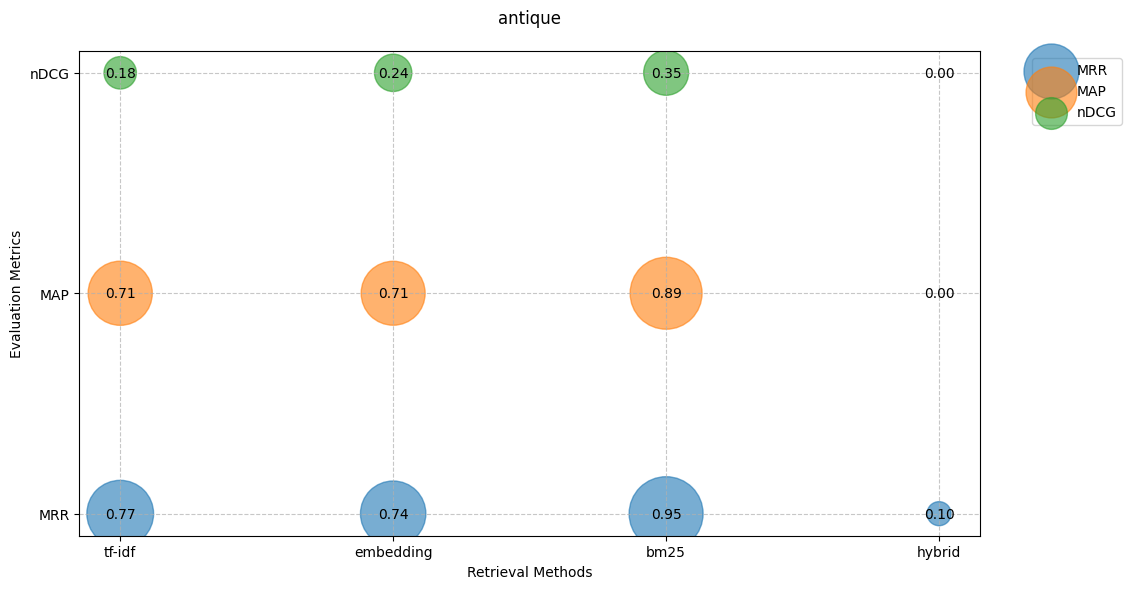

In [43]:
draw_plot("antique", antique_values)

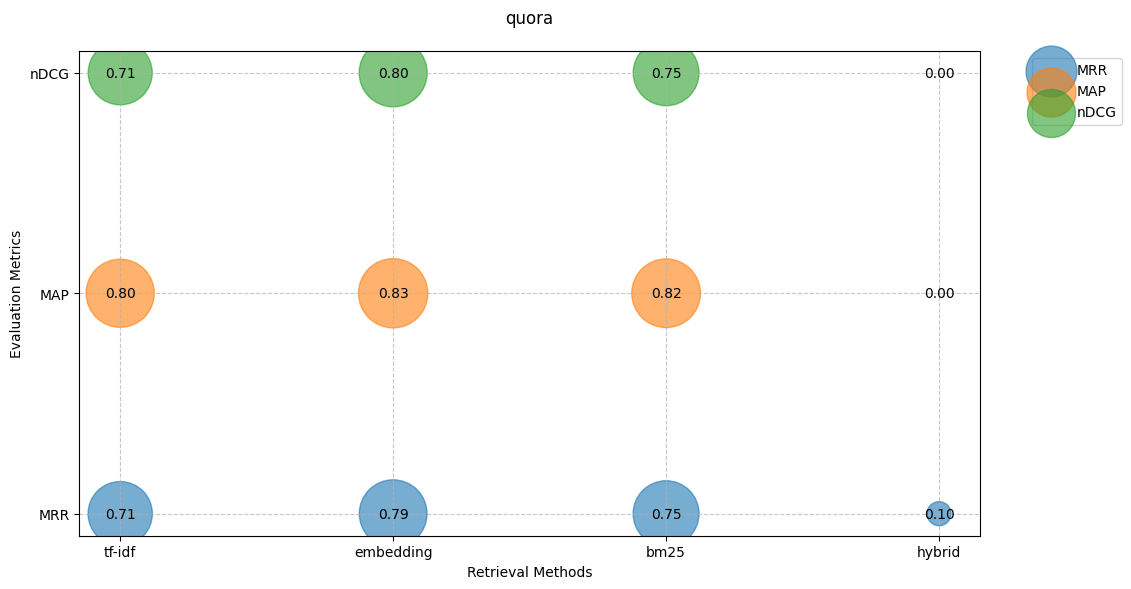

In [44]:
draw_plot("quora", quora_values)

In [ ]:
embedding_methods = ["embedding without vector store", "embedding with vector store"]
embedding_metrics = ["MRR", "MAP", "nDCG"]
x_pos = np.arange(len(embedding_methods))
y_pos = np.arange(len(embedding_metrics))

def draw_plot(dataset_name, values):

    plt.figure(figsize = (10, 6))

    for i, metric in enumerate(embedding_metrics):
        plt.scatter(x_pos, [y_pos[i]]*len(embedding_methods), s = values[i]*3000, alpha = 0.6, label = embedding_metrics[i])

    for i in range(len(embedding_metrics)):
        for j in range(len(embedding_methods)):
            plt.annotate(f"{values[i, j]:.2f}",
                        (x_pos[j], y_pos[i]),
                        ha = 'center', va = 'center',
                        fontsize = 10
                        )

    plt.xticks(x_pos, embedding_methods)
    plt.yticks(y_pos, embedding_metrics)

    plt.title(dataset_name, pad = 20)
    plt.xlabel("Embedding Retrieval Methods")
    plt.ylabel("Embedding Evaluation Metrics")

    plt.tight_layout()
    plt.grid(True, linestyle = '--', alpha = 0.7)
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')

    plt.show()

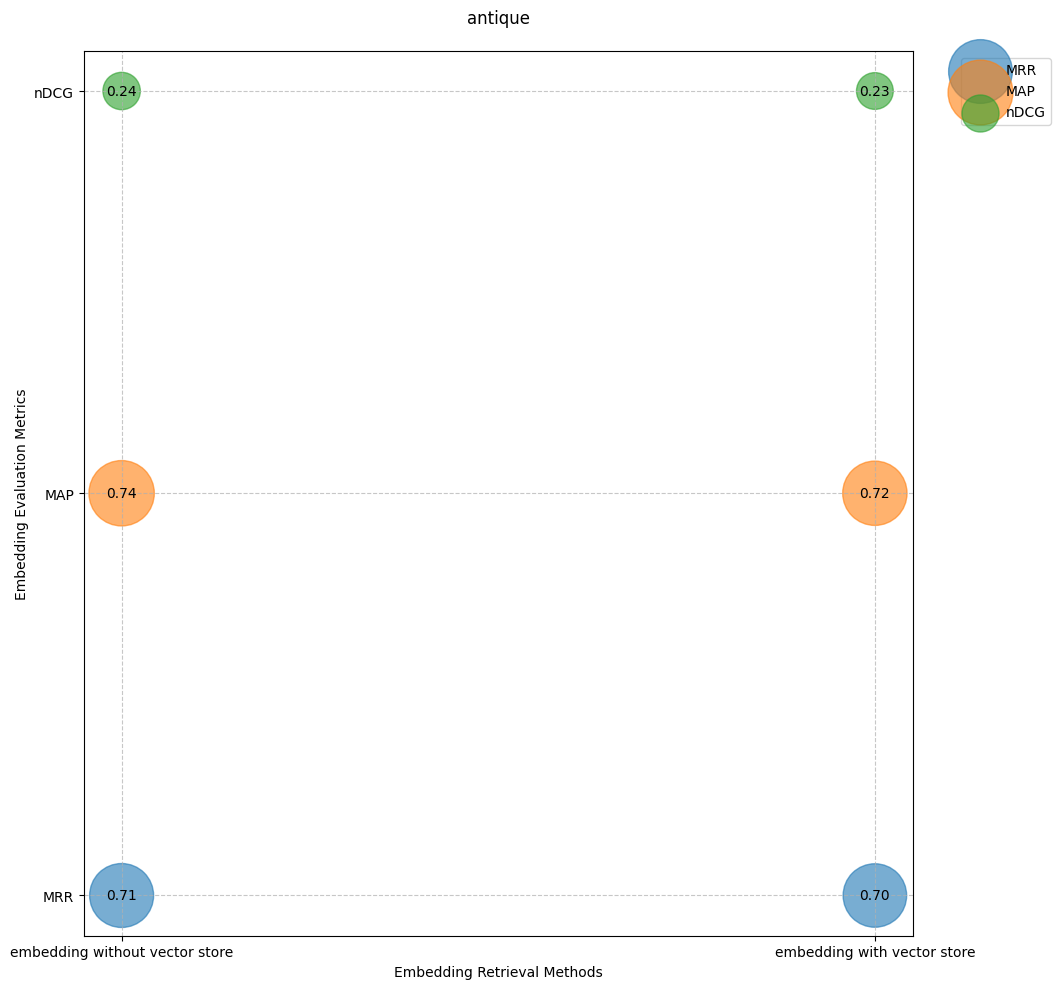

In [56]:
draw_plot("antique", vector_store_antique_values)

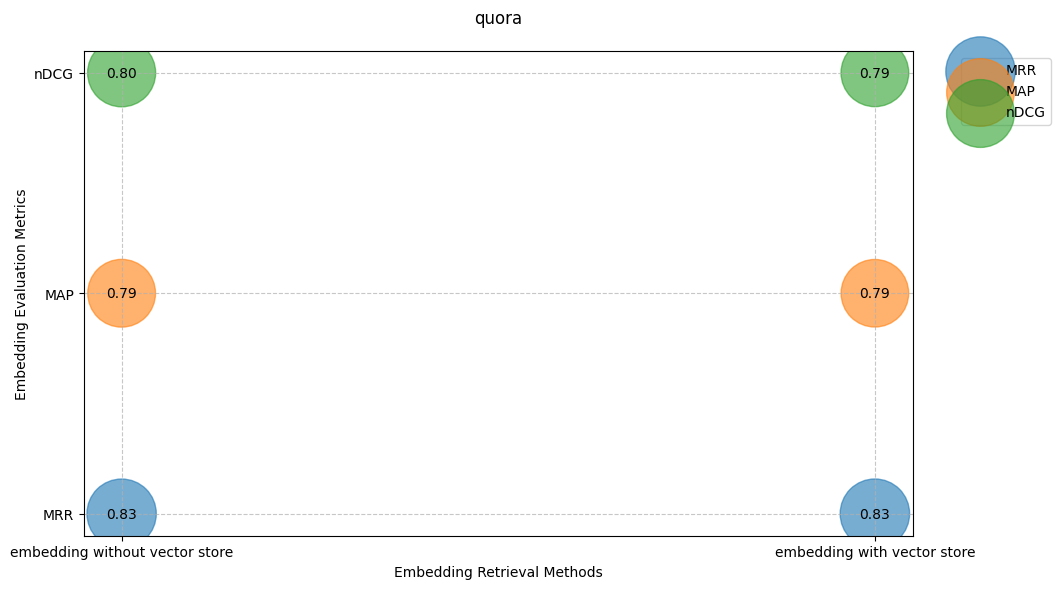

In [54]:
draw_plot("quora", vector_store_quora_values)

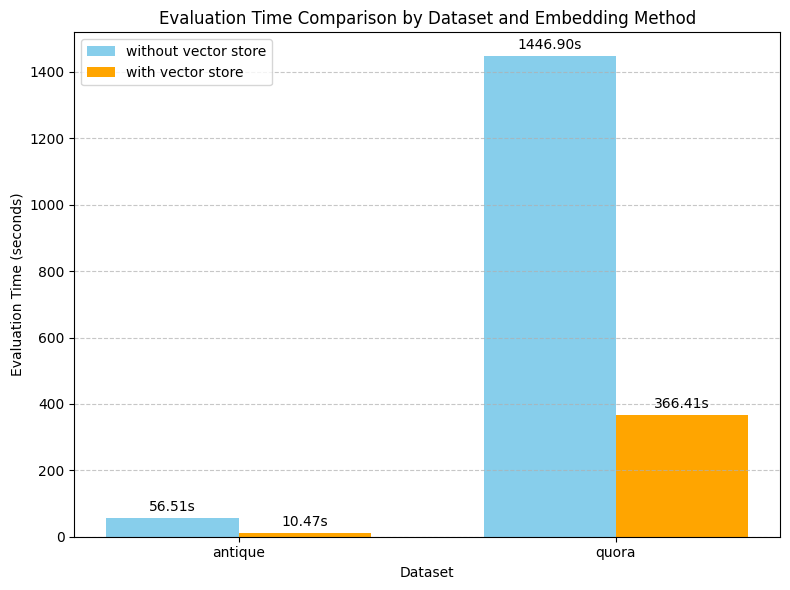

In [64]:
datasets = ['antique', 'quora']
methods = ['without vector store', 'with vector store']

bar_width = 0.35
x = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(8, 6))

# Bars for 'without vector store'
bars1 = ax.bar(x - bar_width/2, [t[0] for t in embedding_evaluation_times], bar_width, label='without vector store', color='skyblue')
# Bars for 'with vector store'
bars2 = ax.bar(x + bar_width/2, [t[1] for t in embedding_evaluation_times], bar_width, label='with vector store', color='orange')

# Annotate bars with time values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}s',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Dataset')
ax.set_ylabel('Evaluation Time (seconds)')
ax.set_title('Evaluation Time Comparison by Dataset and Embedding Method')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
